## EIIE CNN with SEC Sentiment Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gymnasium as gym
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy.typing as npt
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
from stable_baselines3 import DDPG
from stable_baselines3.common.noise import NormalActionNoise

from portfolio_env_framework import *
from data_utils import *
from rewards import *

In [2]:
class TrainDataManager(AbstractDataManager):
    def get_obs_space(self) -> gym.spaces.Box:
        return gym.spaces.Dict({
            'data': gym.spaces.Box(low=-np.inf, high=np.inf, shape=(6, self.universe_size, 10), dtype=np.float32),
            'weights': gym.spaces.Box(low=0, high=1, shape=(self.universe_size+1,), dtype=np.float32)
        })

    def get_data(self) -> tuple[int, int]:
        # read all data
        df = read_crsp_data()
        full_df = read_sec_data(pd.date_range(df.date.min(), df.date.max(), freq='D'), gamma=(1-1/5))
    
        # only include stocks that are present in all dates and in both datasets
        df_ticker_ok = df.TICKER.value_counts() == df.TICKER.value_counts().max()
        not_in_sent = full_df[pd.isnull(full_df.neg) & (full_df.fdate.dt.year > 2009)].TICKERH.unique()
        def is_max_val_count(ticker: str) -> bool:
          return df_ticker_ok[ticker] and (ticker not in ['GOOG', 'EXC']) and (ticker not in not_in_sent)
        df = df[df.apply(lambda row: is_max_val_count(row['TICKER']), axis=1)]
        df = df[(df.date.dt.year >= 2010) & (df.date.dt.year <= 2019)]
        self.times = df.date.unique()[1:]
        self.tickers = df.TICKER.unique()
        full_df = full_df[full_df.apply(lambda row: (row.TICKERH in self.tickers), axis=1)]
    
        # create stock array
        self.stock_df = df.pivot(index='date', columns='TICKER', values='PRC').astype(float)
        self.high_df = df.pivot(index='date', columns='TICKER', values='ASKHI').astype(float)
        self.low_df = df.pivot(index='date', columns='TICKER', values='BIDLO').astype(float)
        
        # adjust for stock splits
        facpr_df = df.pivot(index='date', columns='TICKER', values='FACPR').astype(float)
        self.stock_df = self.stock_df * (1+facpr_df).cumprod(axis=0)
        self.high_df = self.high_df * (1+facpr_df).cumprod(axis=0)
        self.low_df = self.low_df * (1+facpr_df).cumprod(axis=0)
        self.ret = np.log(self.stock_df.pct_change().iloc[1:, :] + 1)
        
        # create pivot tables
        self.neg_sent_df = full_df.pivot(index='fdate', columns='TICKERH', values='neg').astype(float)
        self.pos_sent_df = full_df.pivot(index='fdate', columns='TICKERH', values='pos').astype(float)
        self.unc_sent_df = full_df.pivot(index='fdate', columns='TICKERH', values='unc').astype(float)
        
        self.num_time_periods = len(self.times)-15-1
        self.universe_size = len(self.tickers)
        print(f"{self.universe_size=}")
        return self.num_time_periods, self.universe_size
    
    def get_state(self, t: int, w: npt.NDArray[np.float64], port_val: np.float64) -> npt.NDArray[np.float64]:
        # today is self.times[self.t+10]
        s = np.zeros((6, self.universe_size, 10))
        s[0, :, :] = self.stock_df.loc[self.times[t:t+10], self.tickers].to_numpy().T
        s[1, :, :] = self.high_df.loc[self.times[t:t+10], self.tickers].to_numpy().T
        s[2, :, :] = self.low_df.loc[self.times[t:t+10], self.tickers].to_numpy().T
        s[3, :, :] = self.neg_sent_df.loc[self.times[t:t+10], self.tickers].to_numpy().T
        s[4, :, :] = self.pos_sent_df.loc[self.times[t:t+10], self.tickers].to_numpy().T
        s[5, :, :] = self.unc_sent_df.loc[self.times[t:t+10], self.tickers].to_numpy().T
        return {'data': s, 'weights': w}

    def get_prices(self, t: int) -> npt.NDArray[np.float64]:
        # today is self.times[self.t+10]
        return np.append(self.stock_df.loc[self.times[t+10], :].to_numpy().flatten(), 1.0)

In [3]:
class TestDataManager(AbstractDataManager):
    def get_obs_space(self) -> gym.spaces.Box:
        return gym.spaces.Dict({
            'data': gym.spaces.Box(low=-np.inf, high=np.inf, shape=(6, self.universe_size, 10), dtype=np.float32),
            'weights': gym.spaces.Box(low=0, high=1, shape=(self.universe_size+1,), dtype=np.float32)
        })

    def get_data(self) -> tuple[int, int]:
        # read all data
        df = read_crsp_data()
        full_df = read_sec_data(pd.date_range(df.date.min(), df.date.max(), freq='D'), gamma=(1-1/5))
    
        # only include stocks that are present in all dates and in both datasets
        df_ticker_ok = df.TICKER.value_counts() == df.TICKER.value_counts().max()
        not_in_sent = full_df[pd.isnull(full_df.neg) & (full_df.fdate.dt.year > 2009)].TICKERH.unique()
        def is_max_val_count(ticker: str) -> bool:
          return df_ticker_ok[ticker] and (ticker not in ['GOOG', 'EXC']) and (ticker not in not_in_sent)
        df = df[df.apply(lambda row: is_max_val_count(row['TICKER']), axis=1)]
        df = df[(df.date.dt.year >= 2020) & (df.date.dt.year <= 2024)]
        self.times = df.date.unique()[1:]
        self.tickers = df.TICKER.unique()
        full_df = full_df[full_df.apply(lambda row: (row.TICKERH in self.tickers), axis=1)]
    
        # create stock array
        self.stock_df = df.pivot(index='date', columns='TICKER', values='PRC').astype(float)
        self.high_df = df.pivot(index='date', columns='TICKER', values='ASKHI').astype(float)
        self.low_df = df.pivot(index='date', columns='TICKER', values='BIDLO').astype(float)
        
        # adjust for stock splits
        facpr_df = df.pivot(index='date', columns='TICKER', values='FACPR').astype(float)
        self.stock_df = self.stock_df * (1+facpr_df).cumprod(axis=0)
        self.high_df = self.high_df * (1+facpr_df).cumprod(axis=0)
        self.low_df = self.low_df * (1+facpr_df).cumprod(axis=0)
        self.ret = np.log(self.stock_df.pct_change().iloc[1:, :] + 1)
        
        # create pivot tables
        self.neg_sent_df = full_df.pivot(index='fdate', columns='TICKERH', values='neg').astype(float)
        self.pos_sent_df = full_df.pivot(index='fdate', columns='TICKERH', values='pos').astype(float)
        self.unc_sent_df = full_df.pivot(index='fdate', columns='TICKERH', values='unc').astype(float)

        # read index data and compute volatilities
        idx_df = pd.read_csv('crsp_snpidx_2010_to_2024.csv', dtype={
          'DATE': 'string',
          'vwretd': float
        })
        idx_df.DATE = pd.to_datetime(idx_df.DATE)
        idx_df['vol_20'] = idx_df.vwretd.rolling(20).std()
        idx_df['vol_60'] = idx_df.vwretd.rolling(60).std()
        idx_df.set_index('DATE', inplace=True)
        self.idx_df = idx_df
        
        self.num_time_periods = len(self.times)-15-1
        self.universe_size = len(self.tickers)
        print(f"{self.universe_size=}")
        return self.num_time_periods, self.universe_size
    
    def get_state(self, t: int, w: npt.NDArray[np.float64], port_val: np.float64) -> npt.NDArray[np.float64]:
        # today is self.times[self.t+10]
        s = np.zeros((6, self.universe_size, 10))
        s[0, :, :] = self.stock_df.loc[self.times[t:t+10], self.tickers].to_numpy().T
        s[1, :, :] = self.high_df.loc[self.times[t:t+10], self.tickers].to_numpy().T
        s[2, :, :] = self.low_df.loc[self.times[t:t+10], self.tickers].to_numpy().T
        s[3, :, :] = self.neg_sent_df.loc[self.times[t:t+10], self.tickers].to_numpy().T
        s[4, :, :] = self.pos_sent_df.loc[self.times[t:t+10], self.tickers].to_numpy().T
        s[5, :, :] = self.unc_sent_df.loc[self.times[t:t+10], self.tickers].to_numpy().T
        return {'data': s, 'weights': w}

    def get_prices(self, t: int) -> npt.NDArray[np.float64]:
        # today is self.times[self.t+10]
        return np.append(self.stock_df.loc[self.times[t+10], :].to_numpy().flatten(), 1.0)

In [4]:
class Custom_EIEE_CNN_Extractor(BaseFeaturesExtractor):
    def __init__(self, observation_space: gym.spaces.Dict, features_dim: int = 1028):
        super(Custom_EIEE_CNN_Extractor, self).__init__(observation_space, features_dim)
        n_channels, self.universe_size, data_len = observation_space['data'].shape
        self.cnn = nn.Sequential(
            nn.Conv2d(n_channels, 6, kernel_size=(1, 3)),
            nn.ReLU(),
            nn.Conv2d(6, 8, kernel_size=(1, 3)),
            nn.ReLU(),
            nn.Conv2d(8, 10, kernel_size=(1, 3)),
            nn.ReLU(),
            nn.Conv2d(10, 12, kernel_size=(1, data_len-6)),
        ).cuda()

    def forward(self, observations: dict[str, torch.Tensor]) -> torch.Tensor:
        x = self.cnn(observations['data'])
        return torch.cat((x.flatten(start_dim=1), observations['weights'].flatten(start_dim=1)), dim=1)

In [5]:
train_env = PortfolioEnvWithTCost(dm=TrainDataManager(), rm=ProfitReward(), cp=0.01, cs=0.01)

# Set seeds
random.seed(42)
np.random.seed(42)
train_env.action_space.seed(43)
torch.manual_seed(42)

model = DDPG('MultiInputPolicy', train_env, buffer_size=4*10**5, verbose=1, policy_kwargs={
  'features_extractor_class': Custom_EIEE_CNN_Extractor,
}, action_noise=NormalActionNoise(mean=0, sigma=0.05*np.ones(80)))
model.learn(total_timesteps=10**10, log_interval=1)
# model.save("cnn_portoflio_policy")

self.universe_size=79
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


c:\Users\sumit\GitRepos\portfolio-rl\venv\Lib\site-packages\stable_baselines3\common\buffers.py:605: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 15.56GB > 15.08GB
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.5e+03  |
|    ep_rew_mean     | 0.00165  |
| time/              |          |
|    episodes        | 1        |
|    fps             | 14       |
|    time_elapsed    | 175      |
|    total_timesteps | 2499     |
| train/             |          |
|    actor_loss      | -0.0428  |
|    critic_loss     | 3.39e-05 |
|    learning_rate   | 0.001    |
|    n_updates       | 2398     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.5e+03  |
|    ep_rew_mean     | 0.484    |
| time/              |          |
|    episodes        | 2        |
|    fps             | 14       |
|    time_elapsed    | 356      |
|    total_timesteps | 4998     |
| train/             |          |
|    actor_loss      | -0.0578  |
|    critic_loss     | 3.45e-05 |
|    learning_rate   | 0.001    |
|    n_updates       | 4897     |
--------------

KeyboardInterrupt: 

In [6]:
model.save("sec_model")

In [7]:
env = PortfolioEnvWithTCost(
    dm=TestDataManager(),
    # dm=TrainDataManager(),
    rm=ProfitReward(),
    cp=0.01,#0.10/365,
    cs=0.01,#0.10/365
)
# env = make_vec_env(PortfolioEnvWithTCost, n_envs=1, env_kwargs={
#     'dm': TestDataManager(),
#     'rm': DifferentialSharpeRatioReward(),
#     'cp': 0.10/365,
#     'cs': 0.10/365
# })
obs, _ = env.reset()

port_val = [1.0]
snp_val = [1.0]
actions = []
ys = []
times_arr = [env.dm.times[env.t+15]]
mus = []

for i in range(900):
    action, _ = model.predict(obs, deterministic=True)
    actions.append(action)
    # print(f"external {action=}")
    obs, rewards, terminated, truncated, info = env.step(action)
    ys.append(env.y)
    mus.append(env.mu)
    times_arr.append(env.dm.times[env.t+15])
    port_val.append(info['port_val'])
    snp_val.append(snp_val[-1] * (1 + env.dm.idx_df[env.dm.idx_df.index == env.dm.times[env.t+15]].vwretd.values[0]))
    if terminated:
        break

self.universe_size=79


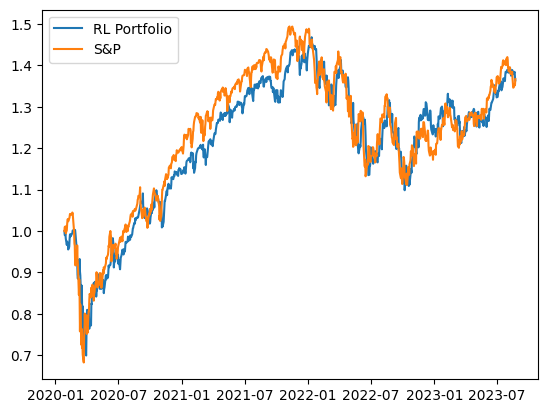

In [8]:
# sec_model
plt.plot(times_arr, np.array(port_val), label='RL Portfolio')
plt.plot(times_arr, np.array(snp_val), label='S&P')
# plt.yscale('log')
plt.legend()
plt.show()

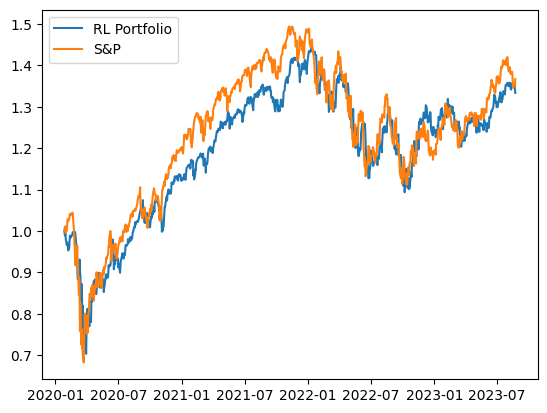

In [16]:
# std=0.05, gamma=1-1/5, train 30min
plt.plot(times_arr, np.array(port_val), label='RL Portfolio')
plt.plot(times_arr, np.array(snp_val), label='S&P')
# plt.yscale('log')
plt.legend()
plt.show()

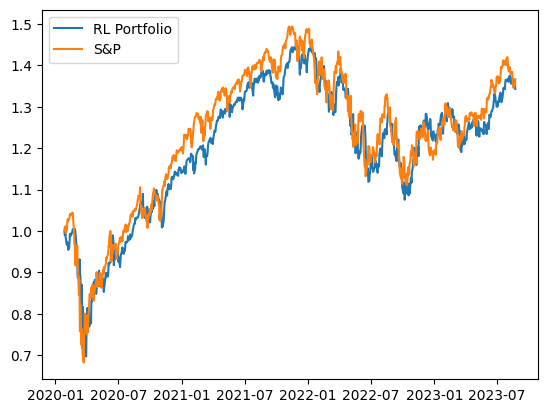

In [12]:
# std=0.04, gamma=1-1/5, train 20min
plt.plot(times_arr, np.array(port_val), label='RL Portfolio')
plt.plot(times_arr, np.array(snp_val), label='S&P')
# plt.yscale('log')
plt.legend()
plt.show()

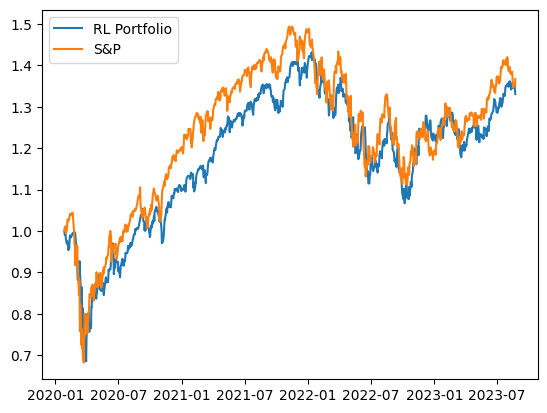

In [9]:
# std=0.03, gamma=1-1/5, train 10min
plt.plot(times_arr, np.array(port_val), label='RL Portfolio')
plt.plot(times_arr, np.array(snp_val), label='S&P')
# plt.yscale('log')
plt.legend()
plt.show()

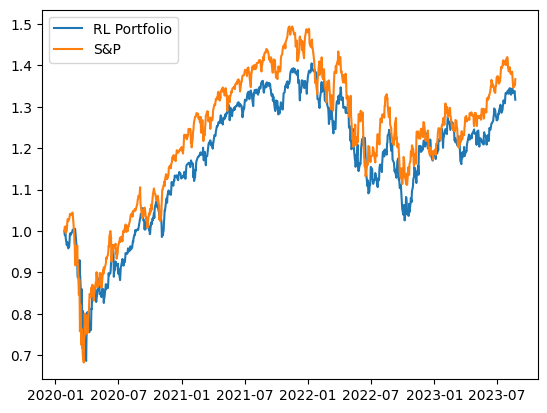

In [9]:
# std=0.02, gamma=1-1/5, train 15min
plt.plot(times_arr, np.array(port_val), label='RL Portfolio')
plt.plot(times_arr, np.array(snp_val), label='S&P')
# plt.yscale('log')
plt.legend()
plt.show()

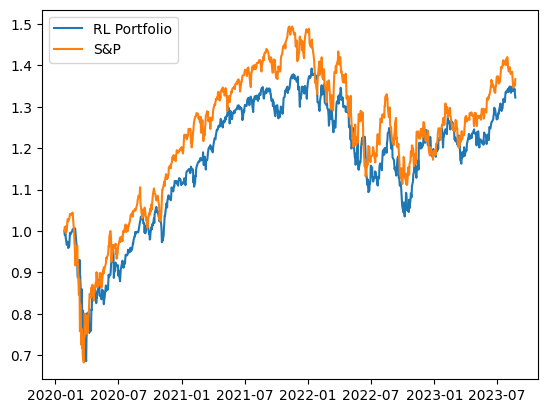

In [9]:
# std=0.02, gamma=1-1/30, train 20min
plt.plot(times_arr, np.array(port_val), label='RL Portfolio')
plt.plot(times_arr, np.array(snp_val), label='S&P')
# plt.yscale('log')
plt.legend()
plt.show()

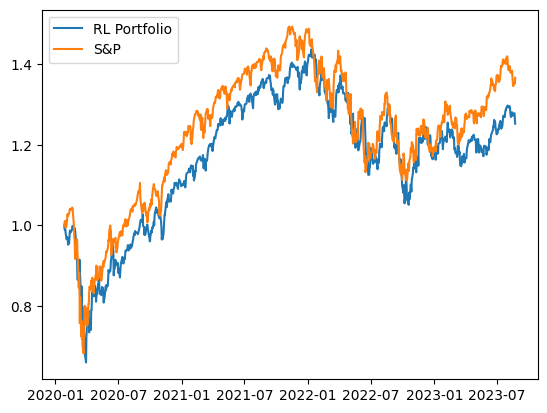

In [37]:
# actual sec, training 20m, std=0.01
plt.plot(times_arr, np.array(port_val), label='RL Portfolio')
plt.plot(times_arr, np.array(snp_val), label='S&P')
# plt.yscale('log')
plt.legend()
plt.show()

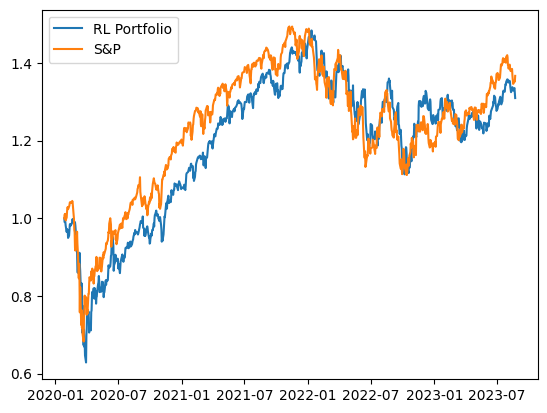

In [34]:
# actual sec, training 10m, std=0.02, slightly larger buffer
plt.plot(times_arr, np.array(port_val), label='RL Portfolio')
plt.plot(times_arr, np.array(snp_val), label='S&P')
# plt.yscale('log')
plt.legend()
plt.show()

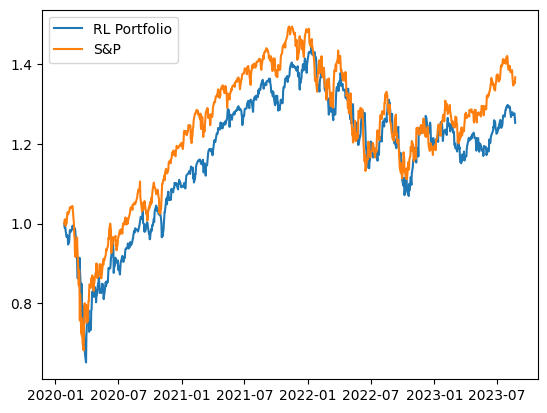

In [31]:
# actual sec, training 10m, std=0.03
plt.plot(times_arr, np.array(port_val), label='RL Portfolio')
plt.plot(times_arr, np.array(snp_val), label='S&P')
# plt.yscale('log')
plt.legend()
plt.show()

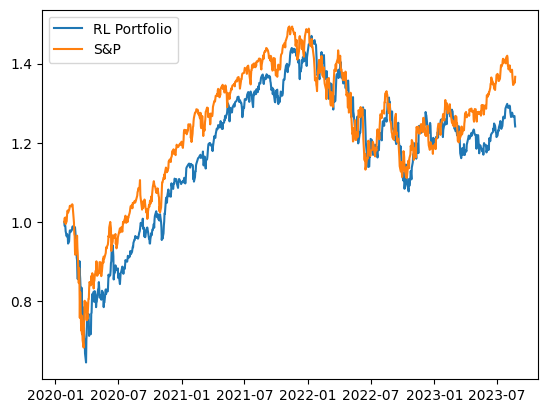

In [28]:
# actual sec, training 15m, std=0.05 (please work??)
plt.plot(times_arr, np.array(port_val), label='RL Portfolio')
plt.plot(times_arr, np.array(snp_val), label='S&P')
# plt.yscale('log')
plt.legend()
plt.show()

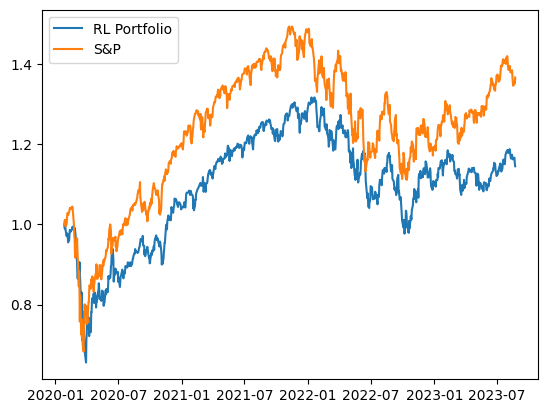

In [20]:
# actual sec, training 20m, std=0.1
plt.plot(times_arr, np.array(port_val), label='RL Portfolio')
plt.plot(times_arr, np.array(snp_val), label='S&P')
# plt.yscale('log')
plt.legend()
plt.show()

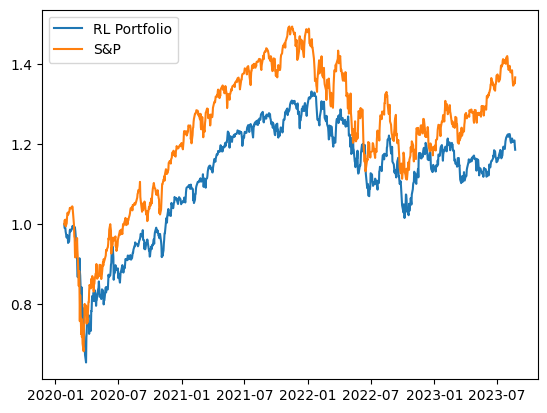

In [17]:
# actual sec, no training
plt.plot(times_arr, np.array(port_val), label='RL Portfolio')
plt.plot(times_arr, np.array(snp_val), label='S&P')
# plt.yscale('log')
plt.legend()
plt.show()

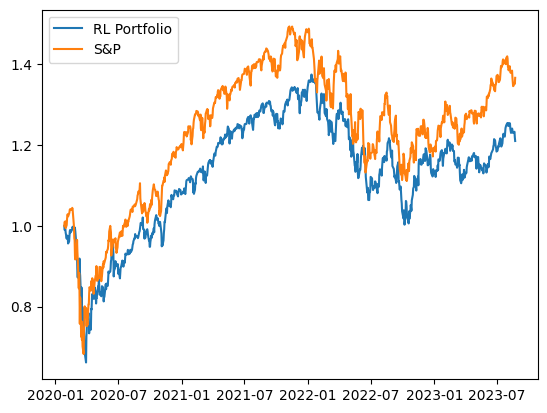

In [12]:
# sec, no training
plt.plot(times_arr, np.array(port_val), label='RL Portfolio')
plt.plot(times_arr, np.array(snp_val), label='S&P')
# plt.yscale('log')
plt.legend()
plt.show()

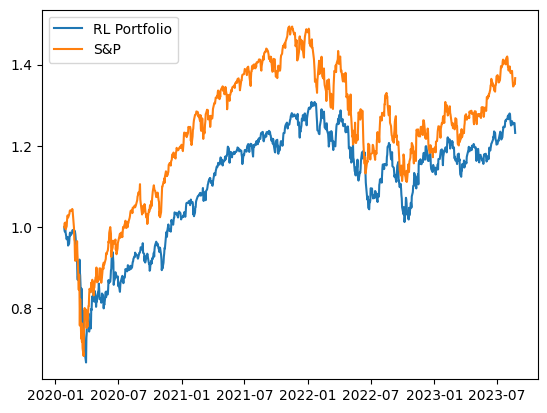

In [19]:
# basic, no training
plt.plot(times_arr, np.array(port_val), label='RL Portfolio')
plt.plot(times_arr, np.array(snp_val), label='S&P')
# plt.yscale('log')
plt.legend()
plt.show()

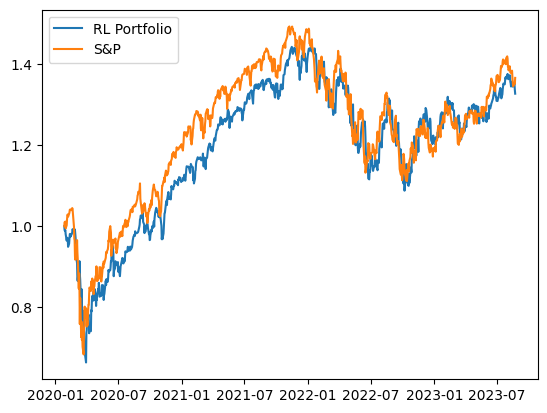

In [16]:
# basic, 15min training
plt.plot(times_arr, np.array(port_val), label='RL Portfolio')
plt.plot(times_arr, np.array(snp_val), label='S&P')
# plt.yscale('log')
plt.legend()
plt.show()

In [54]:
actions[0]

array([-1.,  1., -1., -1., -1.])

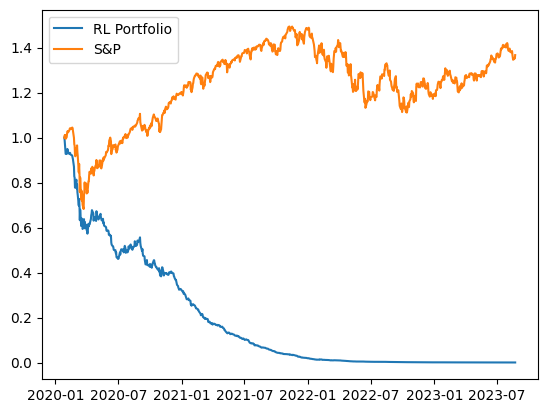

In [12]:
# basic
plt.plot(times_arr, np.array(port_val), label='RL Portfolio')
plt.plot(times_arr, np.array(snp_val), label='S&P')
# plt.yscale('log')
plt.legend()
plt.show()

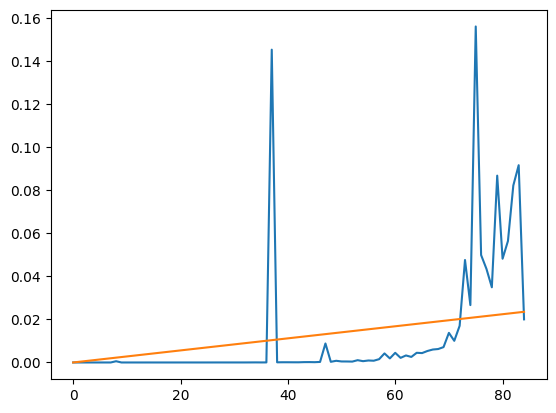

In [17]:
plt.plot((actions[0] + 1)/2)
plt.plot(np.linspace(0, 1, 85) / np.linspace(0, 1, 85).sum())
plt.show()